In [1]:
import sys
sys.path.append("../")


import os
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from patsy import dmatrices
from openpyxl import load_workbook

from linearmodels import PanelOLS
pd.set_option('display.max_columns', None)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/panel/data.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import (Categorical, DataFrame, Index, MultiIndex, Panel, Series,


In [2]:
def coef_with_stars(coef, pvalue):
    coef = round(coef, 2)
    if pvalue >.05:
        coef = str(coef)
    if pvalue <= .05:
        coef = str(coef) + '*'
    if pvalue <= .01:
        coef = coef + '*'
    if pvalue <= .001:
        coef = coef + '*'
    return(coef)
test = coef_with_stars(9.1568, 0.8523)
test

'9.16'

In [3]:
def bonferroni(n_tests, coef, pvalue):
    coef = round(coef, 2)
    if pvalue >(.05/n_tests):
        coef = str(coef)
    if pvalue <= (.05/n_tests):
        coef = str(coef) + '*'
    if pvalue <= (.01/n_tests):
        coef = coef + '*'
    if pvalue <= (.001/n_tests):
        coef = coef + '*'
    return(coef)
test = bonferroni(4, .1, .005)
test

'0.1*'

In [4]:
def format_se(se):
    if se < .005:
        se = '(0.00)'
    else:
        se = '(' + str(round(se, 2)) + ')'
    return se
test = format_se(.0053)
test

'(0.01)'

In [5]:
data_path = '/Users/kylieleblancKylie/domino/dofis/data/'
table_path = '/Users/kylieleblancKylie/domino/dofis/results/Who Needs Rules/'
data = pd.read_csv(os.path.join(data_path, 'clean', 'gdid_subject.csv'),
                  sep=",", low_memory= False)
#load(data)
print(data[data.doi == True].district.nunique())
data.sample(5)

794


,Unnamed: 0,campus,year,test,score,score_std,campname,campischarter,district,distname,distischarter,rating_academic,rating_financial,rating_academic_c,type,type_description,cntyname,students_amind_num,students_asian_num,students_black_num,students_cte_num,students_ell_num,students_frpl_num,students_hisp_num,students_num,students_num_d,students_paci_num,students_sped_num,students_tworaces_num,students_white_num,teachers_badegree_num,teachers_exp_ave,teachers_msdegree_num,teachers_new_num,teachers_nodegree_num,teachers_num,teachers_phddegree_num,teachers_tenure_ave,teachers_turnover_ratio_d,alg_avescore,bio_avescore,eng1_avescore,eng2_avescore,m_3rd_avescore,m_4th_avescore,m_5th_avescore,m_6th_avescore,m_7th_avescore,m_8th_avescore,r_3rd_avescore,r_4th_avescore,r_5th_avescore,r_6th_avescore,r_7th_avescore,r_8th_avescore,s_8th_avescore,us_avescore,alg_numtakers,bio_numtakers,eng1_numtakers,eng2_numtakers,m_3rd_numtakers,m_4th_numtakers,m_5th_numtakers,m_6th_numtakers,m_7th_numtakers,m_8th_numtakers,r_3rd_numtakers,r_4th_numtakers,r_5th_numtakers,r_6th_numtakers,r_7th_numtakers,r_8th_numtakers,s_8th_numtakers,us_numtakers,days_max,days_mean,days_min,class_size_1,class_size_2,class_size_3,class_size_4,class_size_5,class_size_6,class_size_k,class_size_sec_lang,class_size_sec_math,class_size_sec_r,class_size_sec_sci,class_size_sec_ss,stu_teach_ratio,Unnamed: 0_x,link,p_doi,doi_date,total,doi_year,_merge_x,doi,Unnamed: 0_y,_merge_y,cert_area_elem,cert_area_voc,cert_secondary_ela,cert_secondary_math,cert_secondary_sci,certification,certification_report,vocational,county,cnty_pop,students_frpl,students_black,students_hisp,students_white,students_ell,students_sped,students_cte,students_teacher_ratio,geography,charter,district_status,type_urban,type_suburban,type_town,type_rural,eligible,teachers_nodegree,teachers_badegree,teachers_msdegree,teachers_phddegree,r_3rd_std,m_3rd_std,r_4th_std,m_4th_std,r_5th_std,m_5th_std,r_6th_std,m_6th_std,r_7th_std,m_7th_std,r_8th_std,m_8th_std,s_8th_std,alg_std,bio_std,eng1_std,eng2_std,us_std,elem_math,elem_reading,elem,middle_math,middle_reading,middle_science,algebra,biology,eng1,avescores,treatpost,yearpost,yearpre,pre5,pre4,pre3,pre2,pre1,post1,post2,post3,test_by_year,math,reading
178202,204373,101920117,2016,r_3rd_avescore,1345.0,-1.496193,WOODVIEW EL,N,101920,SPRING BRANCH ISD,N,M,Pass,I,B,MAJOR SUBURBAN,HARRIS,17,5,32,0,435,571,525,646,35246,1,54,6,60,33.9,8.700000,9.0,3,0.0,43.900,1.0,6.800000,16.40000,NaN,NaN,NaN,NaN,1352.0,1463.0,1537.0,NaN,NaN,NaN,1345.0,1432.0,1507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.0,90.0,77.0,NaN,NaN,NaN,62.0,40.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.4,21,17.8,19.1,22.5,.,16.8,.,.,.,.,.,14.700000,698.0,https://www.springbranchisd.com/about/board-of...,0.003759,2016-04-01,3.0,2017.0,both,True,4732.0,left_only,1.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,HARRIS,4565.0,0.883901,0.049536,0.812693,0.092879,0.673375,0.083591,0.0,14.715262,Suburban,False,doi,0,1,0,0,1,0.000000,0.772210,0.205011,0.022779,-1.472260,-1.478251,-1.259534,-1.044309,-0.780633,-0.895489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.139349,-1.170809,-1.155079,NaN,NaN,NaN,NaN,NaN,NaN,-1.155079,False,0.0,-1.0,0,0,0,0,1,0,0,0,r_3rd_avescore2016,0,1
130368,156478,220906104,2013,m_3rd_avescore,1418.0,-0.466645,TIMBERLINE EL,N,220906,GRAPEVINE-COLLEYVILLE ISD,N,M,NaN,I,B,MAJOR SUBURBAN,TARRANT,7,21,40,0,392,561,488,735,13328,0,55,12,167,NaN,9.800000,NaN,4,NaN,48.000,NaN,7.000000,14.40000,NaN,NaN,NaN,NaN,1418.0,1468.0,1513.0,NaN,NaN,NaN,1426.0,1483.0,1501.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0,115.0,104.0,2.0,NaN,NaN,58.0,89.0,106.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.6,21.6,18.8,24.2,23.4,2,15.4,.,.,.,.,.,15.400000,306.0,https://www.gcisd.net/UserFiles/Servers/Server...,0.999025,2017-08-01,4.0,2018.0,both,True,7306.0,left_only,0.866667,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,TARRANT,1985.0,0.763265,0.054422,0.663946,0.227211,0.533333,0.074830,0.0,15.312500,Suburban,False,doi,0,1,0,0,1,NaN,NaN,N

# Create HTE Variables

In [6]:
data_pre = data.loc[data.pre1 == 1]
data_pre['avescores_pre'] = data_pre.groupby('campus')['score_std'].transform('mean')
data_pre = data_pre.drop_duplicates(subset = 'campus')
data_pre = data_pre.rename(columns = {'students_hisp': 'students_hisp_pre',
                                     'teachers_turnover_ratio_d': 'teachers_turnover_pre',
                                     'students_ell': 'students_ell_pre',
                                      'students_white': 'students_white_pre',
                                      'students_black': 'students_black_pre',
                                     'students_sped': 'students_sped_pre',
                                     'score_std': 'score_std_pre',
                                    'students_num': 'students_num_pre'})
for var in ['students_hisp_pre', 'students_ell_pre', 'students_white_pre', 'students_black_pre',
            'students_num_pre', 'teachers_turnover_pre', 'avescores_pre']:
    for p in [.25, .5, .75, 1]:
        num = str(int(p * 100))
        newvar = var + num
        if p == .25:
            data_pre[newvar] = np.where(data_pre[var] <= data_pre[var].quantile(p), 1, 0)
        if p > .25:
            lp = p - .25
            data_pre[newvar] = np.where(((data_pre[var] > data_pre[var].quantile(lp)) &
                                         (data_pre[var] <= data_pre[var].quantile(p))), 1, 0)
variables = ['campus']
variables = variables + (list(data_pre.filter(regex = ("_pre"))))
data_pre = data_pre[variables]
data_pre = data_pre.merge(data[data.year == 2016][['campus', 'type_urban', 'type_suburban', 'type_town', 'type_rural']], 
                          how = 'left', left_on = ['campus'], right_on = ['campus'])
data_pre = data_pre.rename(columns = {'type_urban': 'type_urban_pre',
                                      'type_suburban': 'type_suburban_pre',
                                      'type_town': 'type_town_pre',
                                      'type_rural': 'type_rural_pre'})
data_pre['teachers_turnover_pre'] = data_pre.teachers_turnover_pre / 100
data_pre.sample(5)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,campus,score_std_pre,students_num_pre,teachers_turnover_pre,students_black_pre,students_hisp_pre,students_white_pre,students_ell_pre,students_sped_pre,avescores_pre,students_hisp_pre25,students_hisp_pre50,students_hisp_pre75,students_hisp_pre100,students_ell_pre25,students_ell_pre50,students_ell_pre75,students_ell_pre100,students_white_pre25,students_white_pre50,students_white_pre75,students_white_pre100,students_black_pre25,students_black_pre50,students_black_pre75,students_black_pre100,students_num_pre25,students_num_pre50,students_num_pre75,students_num_pre100,teachers_turnover_pre25,teachers_turnover_pre50,teachers_turnover_pre75,teachers_turnover_pre100,avescores_pre25,avescores_pre50,avescores_pre75,avescores_pre100,type_urban_pre,type_suburban_pre,type_town_pre,type_rural_pre
24835,121903101,0.695352,668,0.162,0.047904,0.025449,0.898204,0.008982,0.113772,0.134850,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0.0,0.0,1.0,0.0
23700,101914119,1.513659,886,0.120,0.125282,0.230248,0.418736,0.229120,0.086907,1.653840,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0
25787,170906107,0.351663,621,0.163,0.016103,0.202899,0.761675,0.030596,0.117552,0.420950,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0.0,1.0,0.0,0.0
6052,70901001,0.047315,403,0.036,0.017370,0.312655,0.660050,0.027295,0.126551,0.339011,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0.0,0.0,0.0,1.0
29857,221901113,-0.106589,648,0.157,0.117284,0.535494,0.299383,0.020062,0.135802,-0.421336,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1.0,0.0,0.0,0.0


In [7]:
data_pre.teachers_turnover_pre.quantile(.5)

0.157

Text(0.04,0.02,'The four horizontal lines represent the 25th, 50th, 75th and 100th percentile.')

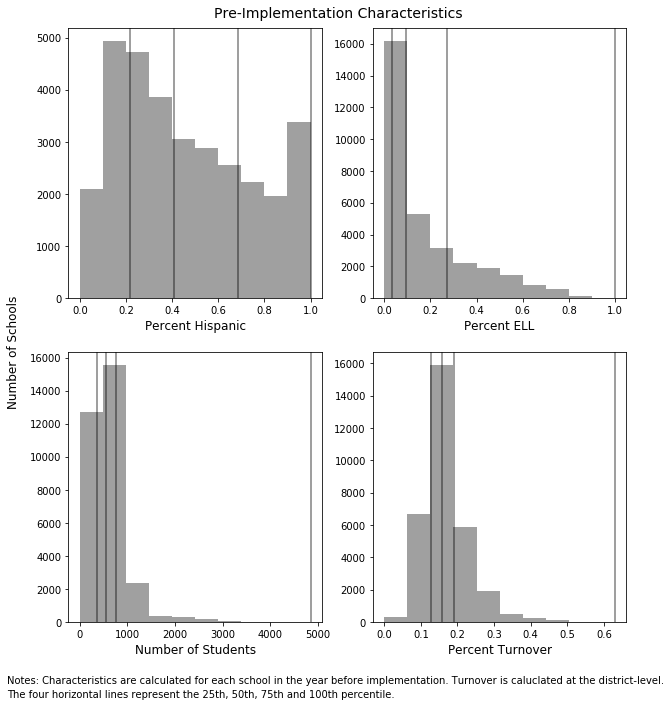

In [8]:
fig, ax = plt.subplots(2,2, sharey=False, sharex = False, figsize=(10, 10))

ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1]


bins = 10

ax1.hist(data_pre.students_hisp_pre, bins, facecolor='gray', alpha=0.75)
ax1.set_xlabel('Percent Hispanic', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax1.axvline(data_pre.students_hisp_pre.quantile(p), color = 'black', alpha = 0.5 )


ax2.hist(data_pre.students_ell_pre, bins, facecolor='gray', alpha=0.75)
ax2.set_xlabel('Percent ELL', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax2.axvline(data_pre.students_ell_pre.quantile(p), color = 'black', alpha = 0.5 )

ax3.hist(data_pre.students_num_pre,  bins, facecolor='gray', alpha=0.75)
ax3.set_xlabel('Number of Students', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax3.axvline(data_pre.students_num_pre.quantile(p), color = 'black', alpha = 0.5 )


ax4.hist(data_pre.teachers_turnover_pre.dropna(),  bins, facecolor='gray', alpha=0.75)
ax4.set_xlabel('Percent Turnover', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax4.axvline(data_pre.teachers_turnover_pre.quantile(p), color = 'black', alpha = 0.5 )


fig.text(0.04, 0.5, 'Number of Schools', va='center', rotation='vertical', fontsize = 12)
fig.suptitle('Pre-Implementation Characteristics', fontsize = 14)
fig.subplots_adjust(top=0.95)
fig.savefig(table_path + 'Pre-Implementation Characteristics.png')

fig.text(0.04, 0.04, 'Notes: Characteristics are calculated for each school in the year before implementation.'
        ' Turnover is caluclated at the district-level.')
fig.text(0.04, 0.02,'The four horizontal lines represent the 25th, 50th, 75th and 100th percentile.')

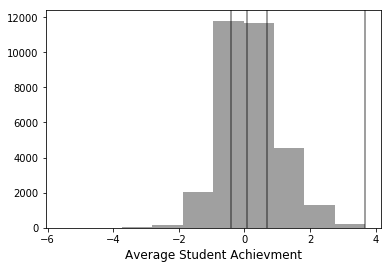

In [9]:
fig, ax = plt.subplots(1,1, sharey=True, sharex = False)


bins = 10

ax.hist(data_pre.avescores_pre, bins, facecolor='gray', alpha=0.75)
ax.set_xlabel('Average Student Achievment', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax.axvline(data_pre.avescores_pre.quantile(p), color = 'black', alpha = 0.5 )

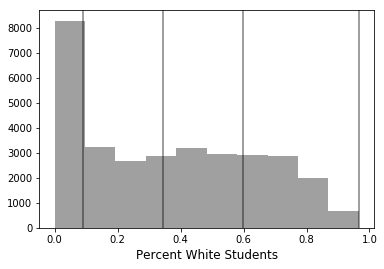

In [10]:
fig, ax = plt.subplots(1,1, sharey=True, sharex = False)


bins = 10

ax.hist(data_pre.students_white_pre, bins, facecolor='gray', alpha=0.75)
ax.set_xlabel('Percent White Students', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax.axvline(data_pre.students_white_pre.quantile(p), color = 'black', alpha = 0.5 )

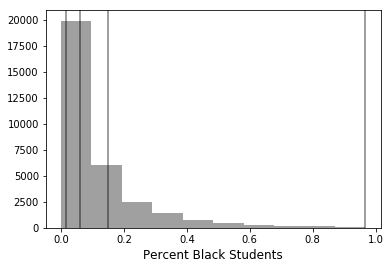

In [11]:
fig, ax = plt.subplots(1,1, sharey=True, sharex = False)


bins = 10

ax.hist(data_pre.students_black_pre, bins, facecolor='gray', alpha=0.75)
ax.set_xlabel('Percent Black Students', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax.axvline(data_pre.students_black_pre.quantile(p), color = 'black', alpha = 0.5 )

In [12]:
data = data.reset_index()
data_pre = data_pre.reset_index()

In [13]:
data = data.reset_index().set_index(['campus', 'test'])
data_pre = data_pre.reset_index().set_index(['campus'])
data.head()

level_0  index  Unnamed: 0  year   score  score_std  \
campus    test                                                                  
109901001 alg_avescore          0      0           0  2012  4069.0  -0.002635   
          bio_avescore          1      1           1  2012  3852.0  -0.712471   
          eng1_avescore         2      2           2  2012  4076.0   0.501276   
          m_3rd_avescore        3      3           3  2012  1463.0   0.269832   
          m_4th_avescore        4      4           4  2012  1494.0  -0.590598   

                               campname campischarter  district    distname  \
campus    test                                                                
109901001 alg_avescore    ABBOTT SCHOOL             N    109901  ABBOTT ISD   
          bio_avescore    ABBOTT SCHOOL             N    109901  ABBOTT ISD   
          eng1_avescore   ABBOTT SCHOOL             N    109901  ABBOTT ISD   
          m_3rd_avescore  ABBOTT SCHOOL             N    109901  ABBOTT ISD   
          m_4th_avescore  ABBOTT SCHOOL             N    109901  ABBOTT ISD   

                         distischarter rating_academic rating_financial  \
campus    test                                                            
109901001 alg_avescore               N             NaN              NaN   
          bio_avescore               N             NaN              NaN   
          eng1_avescore              N             NaN              NaN   
          m_3rd_avescore             N             NaN              NaN   
          m_4th_avescore             N             NaN              NaN   

                         rating_academic_c type type_description cntyname  \
campus    test                                                              
109901001 alg_avescore                 NaN    H            RURAL     HILL   
          bio_avescore                 NaN    H            RURAL     HILL   
          eng1_avescore                NaN    H            RURAL     HILL   
          m_3rd_avescore               NaN    H            RURAL     HILL   
          m_4th_avescore               NaN    H            RURAL     HILL   

                          students_amind_num  students_asian_num  \
campus    test                                                     
109901001 alg_avescore                     0                   0   
          bio_avescore                     0                   0   
          eng1_avescore                    0                   0   
          m_3rd_avescore                   0                   0   
          m_4th_avescore                   0                   0   

                          students_black_num  students_cte_num  \
campus    test                                                   
109901001 alg_avescore                     1               115   
          bio_avescore                     1               115   
          eng1_avescore                    1               115   
          m_3rd_avescore                   1               115   
          m_4th_avescore                   1               115   

                          students_ell_num  students_frpl_num  \
campus    test                                                  
109901001 alg_avescore                   1                101   
          bio_avescore                   1                101   
          eng1_avescore                  1                101   
          m_3rd_avescore                 1                101   
          m_4th_avescore                 1                101   

                          students_hisp_num  students_num  students_num_d  \
campus    test                                                              
109901001 alg_avescore                   30           296             296   
          bio_avescore                   30           296             296   
          eng1_avescore                  30           296             296   
          m_3rd_avescore                 30           296

In [14]:
data_hte = data.reset_index().merge(data_pre, left_on = 'campus', right_on = 'campus', how = 'left')
data_hte.head(5)

,campus,test,level_0_x,index_x,Unnamed: 0,year,score,score_std,campname,campischarter,district,distname,distischarter,rating_academic,rating_financial,rating_academic_c,type,type_description,cntyname,students_amind_num,students_asian_num,students_black_num,students_cte_num,students_ell_num,students_frpl_num,students_hisp_num,students_num,students_num_d,students_paci_num,students_sped_num,students_tworaces_num,students_white_num,teachers_badegree_num,teachers_exp_ave,teachers_msdegree_num,teachers_new_num,teachers_nodegree_num,teachers_num,teachers_phddegree_num,teachers_tenure_ave,teachers_turnover_ratio_d,alg_avescore,bio_avescore,eng1_avescore,eng2_avescore,m_3rd_avescore,m_4th_avescore,m_5th_avescore,m_6th_avescore,m_7th_avescore,m_8th_avescore,r_3rd_avescore,r_4th_avescore,r_5th_avescore,r_6th_avescore,r_7th_avescore,r_8th_avescore,s_8th_avescore,us_avescore,alg_numtakers,bio_numtakers,eng1_numtakers,eng2_numtakers,m_3rd_numtakers,m_4th_numtakers,m_5th_numtakers,m_6th_numtakers,m_7th_numtakers,m_8th_numtakers,r_3rd_numtakers,r_4th_numtakers,r_5th_numtakers,r_6th_numtakers,r_7th_numtakers,r_8th_numtakers,s_8th_numtakers,us_numtakers,days_max,days_mean,days_min,class_size_1,class_size_2,class_size_3,class_size_4,class_size_5,class_size_6,class_size_k,class_size_sec_lang,class_size_sec_math,class_size_sec_r,class_size_sec_sci,class_size_sec_ss,stu_teach_ratio,Unnamed: 0_x,link,p_doi,doi_date,total,doi_year,_merge_x,doi,Unnamed: 0_y,_merge_y,cert_area_elem,cert_area_voc,cert_secondary_ela,cert_secondary_math,cert_secondary_sci,certification,certification_report,vocational,county,cnty_pop,students_frpl,students_black,students_hisp,students_white,students_ell,students_sped,students_cte,students_teacher_ratio,geography,charter,district_status,type_urban,type_suburban,type_town,type_rural,eligible,teachers_nodegree,teachers_badegree,teachers_msdegree,teachers_phddegree,r_3rd_std,m_3rd_std,r_4th_std,m_4th_std,r_5th_std,m_5th_std,r_6th_std,m_6th_std,r_7th_std,m_7th_std,r_8th_std,m_8th_std,s_8th_std,alg_std,bio_std,eng1_std,eng2_std,us_std,elem_math,elem_reading,elem,middle_math,middle_reading,middle_science,algebra,biology,eng1,avescores,treatpost,yearpost,yearpre,pre5,pre4,pre3,pre2,pre1,post1,post2,post3,test_by_year,math,reading,level_0_y,index_y,score_std_pre,students_num_pre,teachers_turnover_pre,students_black_pre,students_hisp_pre,students_white_pre,students_ell_pre,students_sped_pre,avescores_pre,students_hisp_pre25,students_hisp_pre50,students_hisp_pre75,students_hisp_pre100,students_ell_pre25,students_ell_pre50,students_ell_pre75,students_ell_pre100,students_white_pre25,students_white_pre50,students_white_pre75,students_white_pre100,students_black_pre25,students_black_pre50,students_black_pre75,students_black_pre100,students_num_pre25,students_num_pre50,students_num_pre75,students_num_pre100,teachers_turnover_pre25,teachers_turnover_pre50,teachers_turnover_pre75,teachers_turnover_pre100,avescores_pre25,avescores_pre50,avescores_pre75,avescores_pre100,type_urban_pre,type_suburban_pre,type_town_pre,type_rural_pre
0,109901001,alg_avescore,0,0,0,2012,4069.0,-0.002635,ABBOTT SCHOOL,N,109901,ABBOTT ISD,N,NaN,NaN,NaN,H,RURAL,HILL,0,0,1,115,1,101,30,296,296,0,37,9,256,NaN,17.541667,NaN,0,NaN,22.9742,NaN,13.75,8.174,4069.0,3852.0,4076.0,NaN,1463.0,1494.0,1545.0,1700.0,1688.0,1693.0,1466.0,1512.0,1539.0,1647.0,1690.0,1699.0,3808.0,NaN,26.0,26.0,26.0,NaN,16.0,22.0,20.0,17.0,15.0,26.0,16.0,22.0,21.0,19.0,16.0,26.0,26.0,NaN,NaN,NaN,NaN,21,21,17,22,20.6,11.6,20,9.3,11.7,8.5,12.7,16.2,12.884018,0.0,https://www.abbottisd.org/ourpages/auto/2018/3...,0.999955,2018-03-01,11.0,2018.0,both,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HILL,36.0,0.341216,0.003378,0.101351,0.864865,0.003378,0.125,0.388514,12.884018,Rural,False,doi,0,0,0,1,1,NaN,NaN,NaN,NaN,0.712273,0.333386,0.093541,-0.545061,-0.232009,-0.767251,1.064115,1.31147,0.993662,0.843115,0.51854,0.774769,0.159776,0.088879,-0.592073,0.577864,NaN,NaN,-0.326309,0.191269,-0.06752,0.976451,0.

In [15]:
#convert year to datetime
df = data_hte.reset_index()
df['year'] = pd.to_datetime(df['year'], format='%Y')
#add column year to index
df = df.set_index(['year', 'campus'])
#swap indexes
df.index = df.index.swaplevel(0,1)
df[['district', 'doi_year','treatpost']].sample(5, random_state = 8)

,,district,doi_year,treatpost
campus,year,,,
15910127,2017-01-01,15910,2019.0,False
57905268,2014-01-01,57905,2018.0,False
146905101,2019-01-01,146905,2018.0,True
101919043,2013-01-01,101919,2018.0,False
101920114,2014-01-01,101920,2017.0,False


In [42]:
gdid_model = 'score_std ~ + 1 + treatpost + C(test_by_year) + EntityEffects'
linear_gdid_model = 'score_std ~ + 1 + treatpost + yearpost + yearpre  + C(test_by_year) + EntityEffects'
event_study_model = 'score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + post1 + post2 + post3  + C(test_by_year) + EntityEffects'

In [17]:
# Event-study HTE Model
## Math Hispanic

In [40]:
event_study_model = 'score_std ~ + '
for preyr in [5, 4, 3, 2]:
    for p in [25, 50, 75, 100]:
        prevar = 'pre' + str(preyr) + 'hisp' + str(p)
        oldprevar = 'pre' + str(preyr)
        oldcovar = 'students_hisp_pre' + str(p)
        df[prevar] = df[oldprevar] * df[oldcovar]
        event_study_model = event_study_model + prevar + ' + '
for postyr in [1, 2, 3]:
    for p in [25, 50, 75, 100]:    
        postvar = 'post' + str(postyr) + 'hisp' + str(p)
        oldpostvar = 'post' + str(postyr)
        oldcovar = 'students_hisp_pre' + str(p)
        df[postvar] = df[oldpostvar] * df[oldcovar]
        event_study_model = event_study_model + postvar + ' + '    
event_study_model = event_study_model + 'C(test_by_year) + EntityEffects'
event_study_model

'score_std ~ + pre5hisp25 + pre5hisp50 + pre5hisp75 + pre5hisp100 + pre4hisp25 + pre4hisp50 + pre4hisp75 + pre4hisp100 + pre3hisp25 + pre3hisp50 + pre3hisp75 + pre3hisp100 + pre2hisp25 + pre2hisp50 + pre2hisp75 + pre2hisp100 + post1hisp25 + post1hisp50 + post1hisp75 + post1hisp100 + post2hisp25 + post2hisp50 + post2hisp75 + post2hisp100 + post3hisp25 + post3hisp50 + post3hisp75 + post3hisp100 + C(test_by_year) + EntityEffects'

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [ ]:
mod = PanelOLS.from_formula(event_study_model, df[df.math == 1])
res = mod.fit(cov_type='clustered', clusters = df[df.math == 1].district)
print(res)
fig, ax = plt.subplots(2,2, sharey=False, sharex = False, figsize=(10, 10))

ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1]

for ax, p, q in zip ([ax1, ax2, ax3, ax4], ['25', '50', '75', '100'], ['1', '2', '3', '4']):
    nonparametric = []
    nonparametric_se = []
    for coef in ['pre5hisp' + p , 'pre4hisp' + p, 'pre3hisp' + p, 'pre2hisp' + p, 'pre1hisp' + p, 'post1hisp' + p, 'post2hisp' + p, 'post3hisp' + p]:
        nonpar = 0
        nonpar_se = 0
        if coef != 'pre1hisp' + p:
            nonpar = res.params[coef]
            nonpar_se = res.std_errors[coef]
        nonparametric.append(nonpar)
        nonparametric_se.append(nonpar_se)
    coef_df = pd.DataFrame({'coef': nonparametric,
                            'err': nonparametric_se,
                            'year': [-5, -4, -3, -2, -1, 1, 2, 3]
                           })
    coef_df['lb'] = coef_df.coef - (1.96*coef_df.err)
    coef_df['ub'] = coef_df.coef + (1.96*coef_df.err)
    coef_df['errsig'] = coef_df.err *1.96

    #fig, ax = plt.subplots(figsize=(8, 5))

    coef_df.plot(x='year', y='coef', kind='bar', 
                 ax=ax, color='none', 
                 yerr='errsig', legend=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='s', s=120, 
               y=coef_df['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=2)
    ax.xaxis.set_ticks_position('none')
    _ = ax.set_xticklabels(['Pre5', 'Pre4', 'Pre3', 'Pre2', 'Pre1', 'Post1', 'Post2', 'Post3'], 
                           rotation=0)
    ax.set_title('Percent Hispanic Q' + q, fontsize = 16)
fig.savefig(table_path + 'Event Study Math Hispanic.png')

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [ ]:
mod = PanelOLS.from_formula(event_study_model, df[df.reading == 1])
res = mod.fit(cov_type='clustered', clusters = df[df.reading == 1].district)
print(res)
fig, ax = plt.subplots(2,2, sharey=False, sharex = False, figsize=(10, 10))

ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1]

for ax, p, q in zip ([ax1, ax2, ax3, ax4], ['25', '50', '75', '100'], ['1', '2', '3', '4']):
    nonparametric = []
    nonparametric_se = []
    for coef in ['pre5hisp' + p , 'pre4hisp' + p, 'pre3hisp' + p, 'pre2hisp' + p, 'pre1hisp' + p, 'post1hisp' + p, 'post2hisp' + p, 'post3hisp' + p]:
        nonpar = 0
        nonpar_se = 0
        if coef != 'pre1hisp' + p:
            nonpar = res.params[coef]
            nonpar_se = res.std_errors[coef]
        nonparametric.append(nonpar)
        nonparametric_se.append(nonpar_se)
    coef_df = pd.DataFrame({'coef': nonparametric,
                            'err': nonparametric_se,
                            'year': [-5, -4, -3, -2, -1, 1, 2, 3]
                           })
    coef_df['lb'] = coef_df.coef - (1.96*coef_df.err)
    coef_df['ub'] = coef_df.coef + (1.96*coef_df.err)
    coef_df['errsig'] = coef_df.err *1.96

    #fig, ax = plt.subplots(figsize=(8, 5))

    coef_df.plot(x='year', y='coef', kind='bar', 
                 ax=ax, color='none', 
                 yerr='errsig', legend=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='s', s=120, 
               y=coef_df['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=2)
    ax.xaxis.set_ticks_position('none')
    _ = ax.set_xticklabels(['Pre5', 'Pre4', 'Pre3', 'Pre2', 'Pre1', 'Post1', 'Post2', 'Post3'], 
                           rotation=0)
    ax.set_title('Percent Hispanic Q' + q, fontsize = 16)
fig.savefig(table_path + 'Event Study Reading Hispanic.png')

In [211]:
def hte_table(covar, htevar, column, df):
    formula_vars = ''
    covars = ''
    htevars = ''
    hte_list = []
    for p in [25, 50, 75, 100]:
        newvar = htevar + str(p)
        var = covar + str(p)
        if p != 25:
            covars = covars + ' + ' + var
            htevars = htevars + ' + ' + newvar
            hte_list.append(newvar)
        df[newvar] = df['treatpost'] * df[var]

    mod = PanelOLS.from_formula(gdid_model + htevars, df)
    res = mod.fit(cov_type='clustered', clusters = df.district)
    row = 3
    betas = ['treatpost[T.True]'] + hte_list
    for var in betas:
        ws.cell(row= row, column= column).value = bonferroni(5, res.params[var], res.pvalues[var])
        row = row + 1
        ws.cell(row= row, column= column).value = format_se(res.std_errors[var])
        row = row + 1
    wb.save(file)
    print(res)

# Math

In [212]:
# Get table ready
file = table_path + 'table5_gdid_and_event_hte_math.xlsx'
wb = load_workbook(file)
ws = wb.active

In [213]:
hte_table('students_hisp_pre', 'treatpost_hisp', 2, df[df.math == 1])

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2133
Estimator:                   PanelOLS   R-squared (Between):             -0.3756
No. Observations:              811261   R-squared (Within):               0.2133
Date:                Mon, Jan 13 2020   R-squared (Overall):              0.0146
Time:                        15:53:31   Log-likelihood                -6.737e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3701.6
Entities:                        5638   P-value                           0.0000
Avg Obs:                       143.89   Distribution:               F(59,805564)
Min Obs:                       1.0000                                           
Max Obs:                       840.00   F-statistic (robust):             111.04
                            

In [214]:
hte_table('students_black_pre', 'treatpost_black', 3, df[df.math == 1])

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2137
Estimator:                   PanelOLS   R-squared (Between):             -0.3676
No. Observations:              811261   R-squared (Within):               0.2137
Date:                Mon, Jan 13 2020   R-squared (Overall):              0.0191
Time:                        15:54:10   Log-likelihood                -6.735e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3709.7
Entities:                        5638   P-value                           0.0000
Avg Obs:                       143.89   Distribution:               F(59,805564)
Min Obs:                       1.0000                                           
Max Obs:                       840.00   F-statistic (robust):             108.21
                            

In [215]:
hte_table('teachers_turnover_pre', 'treatpost_turnover', 4, df[df.math == 1])

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2135
Estimator:                   PanelOLS   R-squared (Between):             -0.3672
No. Observations:              811261   R-squared (Within):               0.2135
Date:                Mon, Jan 13 2020   R-squared (Overall):              0.0214
Time:                        15:54:50   Log-likelihood                -6.736e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3705.5
Entities:                        5638   P-value                           0.0000
Avg Obs:                       143.89   Distribution:               F(59,805564)
Min Obs:                       1.0000                                           
Max Obs:                       840.00   F-statistic (robust):             111.22
                            

In [216]:
hte_table('avescores_pre', 'treatpost_score', 5, df[df.math == 1])

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2127
Estimator:                   PanelOLS   R-squared (Between):             -0.3529
No. Observations:              811261   R-squared (Within):               0.2127
Date:                Mon, Jan 13 2020   R-squared (Overall):              0.0292
Time:                        15:55:29   Log-likelihood                 -6.74e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3689.8
Entities:                        5638   P-value                           0.0000
Avg Obs:                       143.89   Distribution:               F(59,805564)
Min Obs:                       1.0000                                           
Max Obs:                       840.00   F-statistic (robust):             107.77
                            

In [217]:
formula_vars = ''
for disttype in ['urban', 'suburban', 'town', 'rural']:
    newvar = 'treatpost_' + disttype
    var = 'type_' + disttype + '_pre'
    df[newvar] = df['treatpost'] * df[var]


mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + C(test_by_year) + EntityEffects' 
     + '  + treatpost_town + treatpost_suburban + treatpost_urban'
     + '  + type_town + type_suburban + type_urban', df[df.math == 1])
res = mod.fit(cov_type='clustered', clusters = df[df.math == 1].district)
row = 3
for var in ['treatpost[T.True]', 'treatpost_town', 'treatpost_suburban', 'treatpost_urban']:
    ws.cell(row= row, column= 6).value = bonferroni(5, res.params[var], res.pvalues[var])
    row = row + 1
    ws.cell(row= row, column= 6).value = format_se(res.std_errors[var])
    row = row + 1
wb.save(file)
print(res)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2126
Estimator:                   PanelOLS   R-squared (Between):             -0.3831
No. Observations:              810995   R-squared (Within):               0.2126
Date:                Mon, Jan 13 2020   R-squared (Overall):              0.0090
Time:                        15:56:36   Log-likelihood                -6.739e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3507.8
Entities:                        5598   P-value                           0.0000
Avg Obs:                       144.87   Distribution:               F(62,805335)
Min Obs:                       1.0000                                           
Max Obs:                       840.00   F-statistic (robust):             108.35
                            

# Reading

In [189]:
# Get table ready
file = table_path + 'table6_gdid_and_event_hte_reading.xlsx'
wb = load_workbook(file)
ws = wb.active

In [192]:
hte_table('students_hisp_pre', 'treatpost_hisp', 2, df[df.reading == 1])
hte_table('students_black_pre', 'treatpost_black', 3, df[df.reading == 1])
hte_table('teachers_turnover_pre', 'treatpost_turnover', 4, df[df.reading == 1])
hte_table('avescores_pre', 'treatpost_score', 5, df[df.reading == 1])

formula_vars = ''
for disttype in ['urban', 'suburban', 'town', 'rural']:
    newvar = 'treatpost_' + disttype
    var = 'type_' + disttype + '_pre'
    df[newvar] = df['treatpost'] * df[var]


mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + C(test_by_year) + EntityEffects' 
     + '  + treatpost_town + treatpost_suburban + treatpost_urban'
     + '  + type_town + type_suburban + type_urban', df[df.reading == 1])
res = mod.fit(cov_type='clustered', clusters = df[df.reading == 1].district)
row = 3
for var in ['treatpost[T.True]', 'treatpost_town', 'treatpost_suburban', 'treatpost_urban']:
    ws.cell(row= row, column= 6).value = bonferroni(5, res.params[var], res.pvalues[var])
    row = row + 1
    ws.cell(row= row, column= 6).value = format_se(res.std_errors[var])
    row = row + 1
wb.save(file)
print(res)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1217
Estimator:                   PanelOLS   R-squared (Between):             -0.1179
No. Observations:              760758   R-squared (Within):               0.1217
Date:                Mon, Jan 13 2020   R-squared (Overall):             -0.0068
Time:                        15:37:57   Log-likelihood                -4.948e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1773.8
Entities:                        5637   P-value                           0.0000
Avg Obs:                       134.96   Distribution:               F(59,755062)
Min Obs:                       1.0000                                           
Max Obs:                       840.00   F-statistic (robust):             205.41
                            

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1208
Estimator:                   PanelOLS   R-squared (Between):             -0.1037
No. Observations:              760758   R-squared (Within):               0.1208
Date:                Mon, Jan 13 2020   R-squared (Overall):              0.0039
Time:                        15:38:40   Log-likelihood                -4.952e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1757.8
Entities:                        5637   P-value                           0.0000
Avg Obs:                       134.96   Distribution:               F(59,755062)
Min Obs:                       1.0000                                           
Max Obs:                       840.00   F-statistic (robust):             198.24
                            

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1213
Estimator:                   PanelOLS   R-squared (Between):             -0.0965
No. Observations:              760758   R-squared (Within):               0.1213
Date:                Mon, Jan 13 2020   R-squared (Overall):              0.0102
Time:                        15:39:23   Log-likelihood                 -4.95e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1765.8
Entities:                        5637   P-value                           0.0000
Avg Obs:                       134.96   Distribution:               F(59,755062)
Min Obs:                       1.0000                                           
Max Obs:                       840.00   F-statistic (robust):             215.98
                            

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1206
Estimator:                   PanelOLS   R-squared (Between):             -0.0766
No. Observations:              760758   R-squared (Within):               0.1206
Date:                Mon, Jan 13 2020   R-squared (Overall):              0.0241
Time:                        15:40:07   Log-likelihood                -4.953e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1755.0
Entities:                        5637   P-value                           0.0000
Avg Obs:                       134.96   Distribution:               F(59,755062)
Min Obs:                       1.0000                                           
Max Obs:                       840.00   F-statistic (robust):             198.04
                            

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1191
Estimator:                   PanelOLS   R-squared (Between):             -0.1322
No. Observations:              760500   R-squared (Within):               0.1191
Date:                Mon, Jan 13 2020   R-squared (Overall):             -0.0186
Time:                        15:41:04   Log-likelihood                -4.958e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1646.2
Entities:                        5597   P-value                           0.0000
Avg Obs:                       135.88   Distribution:               F(62,754841)
Min Obs:                       1.0000                                           
Max Obs:                       840.00   F-statistic (robust):             189.23
                            

In [193]:
formula_vars = ''
for disttype in ['urban', 'suburban', 'town', 'rural']:
    newvar = 'treatpost_' + disttype
    var = 'type_' + disttype + '_pre'
    df[newvar] = df['treatpost'] * df[var]


mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + C(test_by_year) + EntityEffects' 
     + '  + treatpost_town + treatpost_suburban + treatpost_urban'
     + '  + type_town + type_suburban + type_urban', df[df.reading == 1])
res = mod.fit(cov_type='clustered', clusters = df[df.reading == 1].district)
row = 3
for var in ['treatpost[T.True]', 'treatpost_town', 'treatpost_suburban', 'treatpost_urban']:
    ws.cell(row= row, column= 6).value = bonferroni(5, res.params[var], res.pvalues[var])
    row = row + 1
    ws.cell(row= row, column= 6).value = format_se(res.std_errors[var])
    row = row + 1
wb.save(file)
print(res)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1191
Estimator:                   PanelOLS   R-squared (Between):             -0.1322
No. Observations:              760500   R-squared (Within):               0.1191
Date:                Mon, Jan 13 2020   R-squared (Overall):             -0.0186
Time:                        15:46:50   Log-likelihood                -4.958e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1646.2
Entities:                        5597   P-value                           0.0000
Avg Obs:                       135.88   Distribution:               F(62,754841)
Min Obs:                       1.0000                                           
Max Obs:                       840.00   F-statistic (robust):             189.23
                            

# Linear GDID Math

In [34]:
df['treatpost_score'] = df['treatpost'] * df['avescores_pre']
df['yearpost_score'] = df['yearpost'] * df['avescores_pre']
df['yearpre_score'] = df['yearpre'] * df['avescores_pre']

In [39]:
linear_hte_model = 'score_std ~ + 1 + treatpost + treatpost_score + yearpost + yearpre  + yearpost_score + yearpre_score+ C(test_by_year) + EntityEffects'
linear_hte_model

'score_std ~ + 1 + treatpost + treatpost_score + yearpost + yearpre  + yearpost_score + yearpre_score+ C(test_by_year) + EntityEffects'

In [48]:
mod = PanelOLS.from_formula(linear_gdid_model, df[(df.math == 1) & (df.avescores_pre25 == 1)])
res = mod.fit(cov_type='clustered', clusters = df[(df.math == 1) & (df.avescores_pre25 == 1)].district)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2567
Estimator:                   PanelOLS   R-squared (Between):             -2.0222
No. Observations:              184216   R-squared (Within):               0.2567
Date:                Tue, Jan 14 2020   R-squared (Overall):             -0.0403
Time:                        17:06:30   Log-likelihood                -1.372e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1087.9
Entities:                        5960   P-value                           0.0000
Avg Obs:                       30.909   Distribution:               F(58,182749)
Min Obs:                       0.0000                                           
Max Obs:                       840.00   F-statistic (robust):             77.363
                            

In [ ]:


linear_gdid_model = 'score_std ~ + 1 + treatpost + yearpost + yearpre + C(test_by_year) + EntityEffects'


    formula_vars = ''
    covars = ''
    htevars = ''
    hte_list = []
    for p in [25, 50, 75, 100]:
        newvar = htevar + str(p)
        var = covar + str(p)
        if p != 25:
            covars = covars + ' + ' + var
            htevars = htevars + ' + ' + newvar
            hte_list.append(newvar)
        df[newvar] = df['treatpost'] * df[var]

    mod = PanelOLS.from_formula(gdid_model + htevars, df)
    res = mod.fit(cov_type='clustered', clusters = df.district)
    row = 3
    betas = ['treatpost[T.True]'] + hte_list
    for var in betas:
        ws.cell(row= row, column= column).value = bonferroni(5, res.params[var], res.pvalues[var])
        row = row + 1
        ws.cell(row= row, column= column).value = format_se(res.std_errors[var])
        row = row + 1
    wb.save(file)
    print(res)